In [ ]:
%pylab inline
import pandas as pd
import scipy as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('WAG_C_M.csv',delimiter=';',dayfirst=True,parse_dates=['month'],index_col=['month'])

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


In [ ]:
def invboxcox(y,lmbda):
  if lmbda == 0:
    return np.exp(y)
  else:
    return np.exp(log(lmbda*y+1)/lmbda)

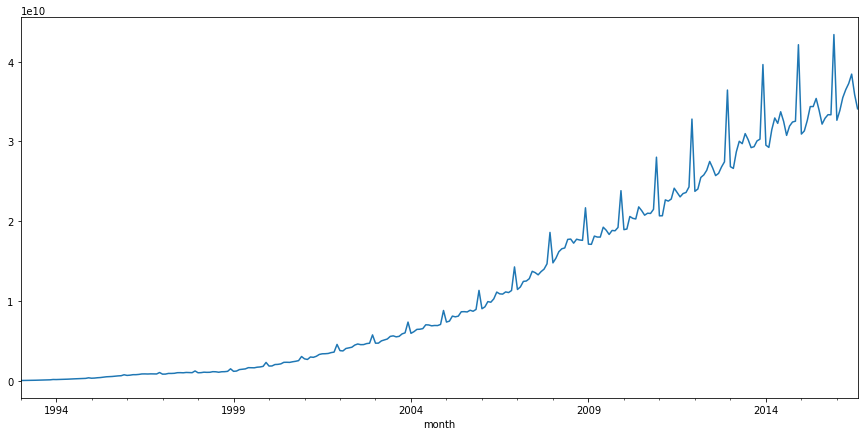

In [ ]:
plt.figure(figsize=(15,7))
df.WAG_C_M = df.WAG_C_M*1000
df.WAG_C_M.plot()
pylab.show()

Анализируя график ряда видно, что имеется ярко выраженный тренд и годовая сезонность. Применим сезонную декомпозицию. И посмотрим на значение критерия Дики-Фуллера. Уберём сезонность - сезонным дифференцированием, тренд - обычным дифференцированием и стабилизируем дисперсию с помощью преобразования Бокса-Кокса.

0.9918495954854735


<Figure size 7200x7200 with 0 Axes>

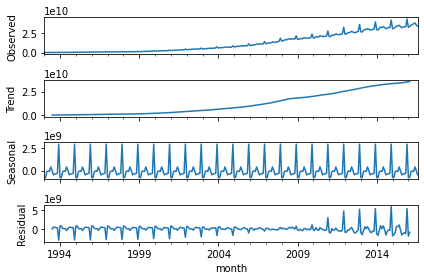

In [ ]:
plt.figure(figsize=(100,100))
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
print(sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

0.2632017402431264


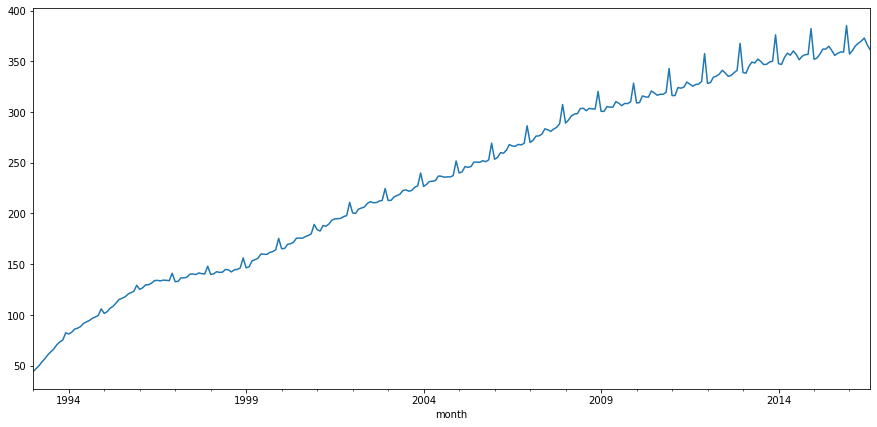

In [ ]:
plt.figure(figsize=(15,7))
df['WAG_BOX'],lmbda = stats.stats.boxcox(df.WAG_C_M)
df.WAG.BOX.plot()
print(lmbda)

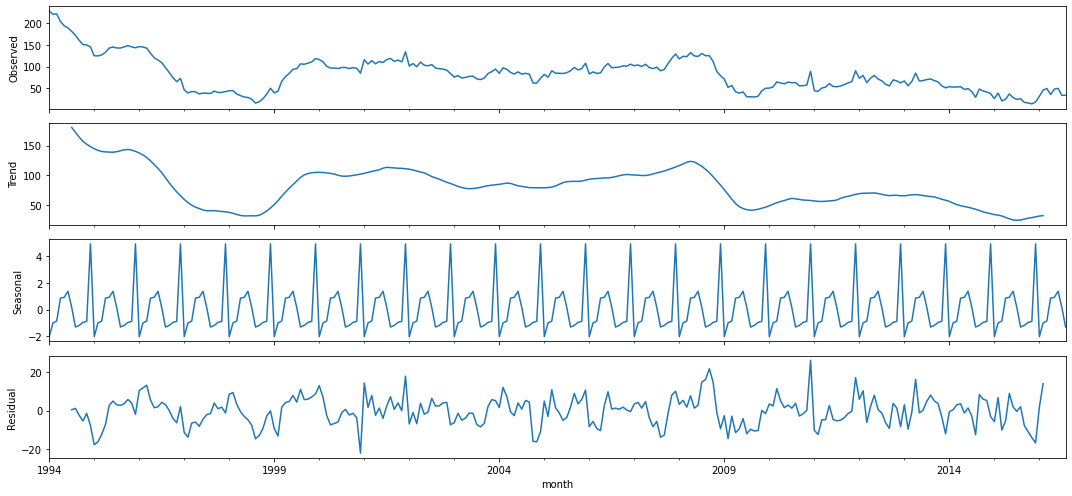

<Figure size 1080x504 with 0 Axes>

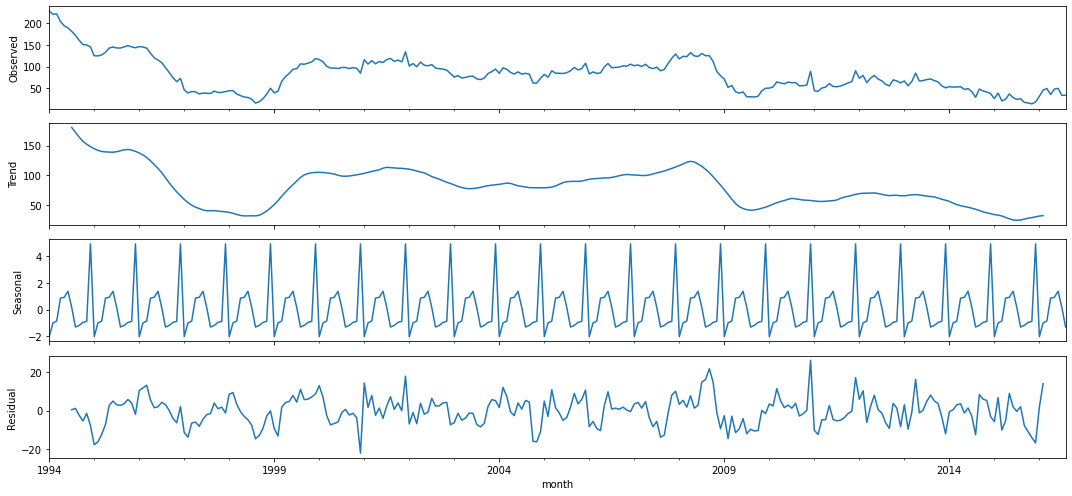

In [ ]:
df['WAG_diff'] = df.WAG_BOX - df.WAG_BOX.shift(12)
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df.WAG_diff[12:]).plot()

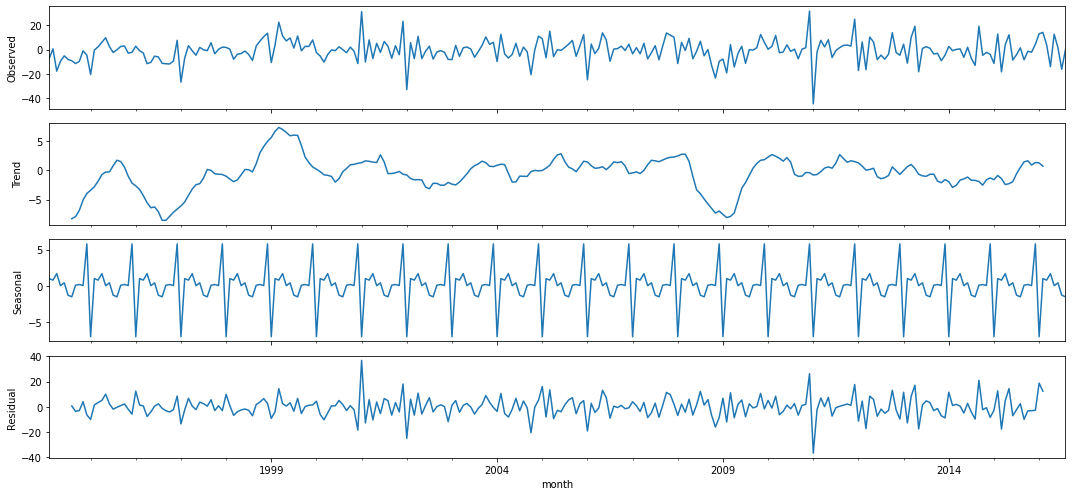

<Figure size 1080x504 with 0 Axes>

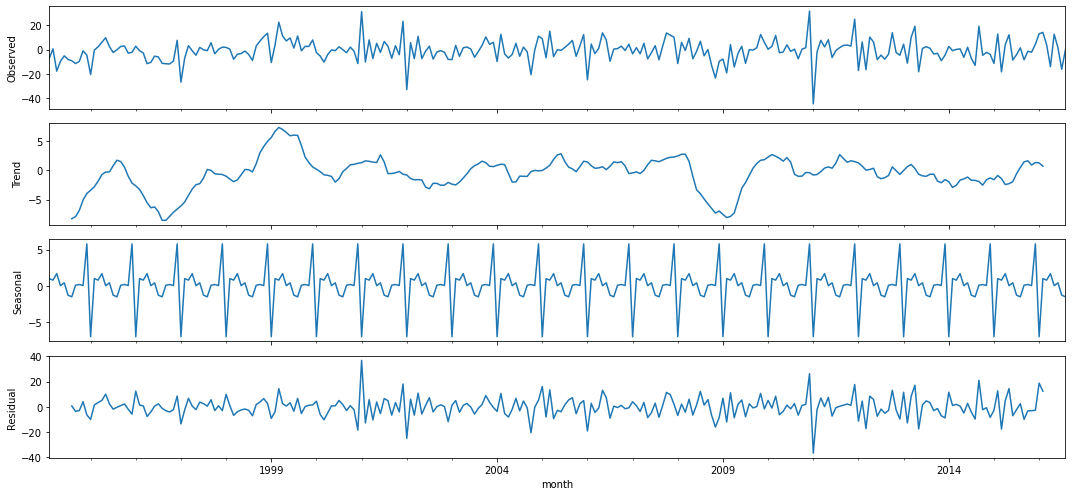

In [ ]:
df['WAG_diff2'] = df.WAG_diff - df.WAG_diff.shift(1)
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df.WAG_diff2[13:]).plot()

После второго обычного дифференцирования мы можем видеть, что наш ряд принял вид случайного шума.

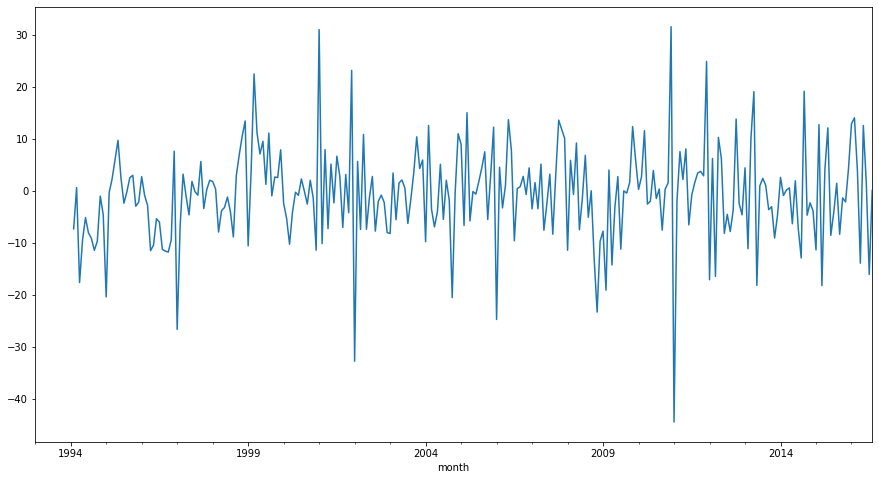

In [ ]:
plt.figure(figsize=(15,8))
df.WAG_diff2.plot()

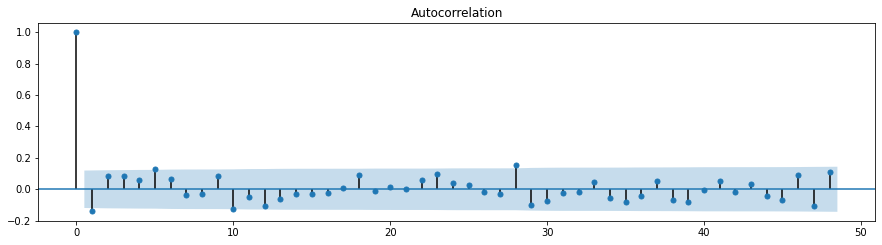

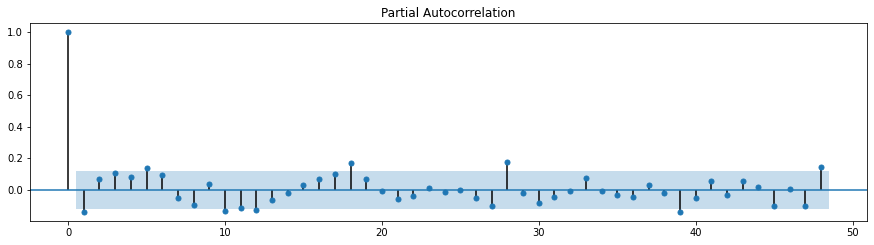

In [ ]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.WAG_diff2[13:].values.squeeze(),lags=48,ax=ax)
pylab.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.WAG_diff2[13:].values.squeeze(),lags=48,ax=ax)
pylab.show()


In [ ]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [ ]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [ ]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
  try:
    model=sm.tsa.statespace.SARIMAX(df.WAG_BOX, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
  except ValueError:
    print('wrong parameters:', param)
    continue
  aic = model.aic
  if aic < best_aic:
    best_model = model
    best_aic = aic
    best_param = param
  results.append([param, model.aic])
warnings.filterwarnings('default')

In [ ]:
result = pd.DataFrame(results,columns=['parameters','aic'])
print(result.sort_values(by='aic',ascending=True))

      parameters          aic
32  (2, 2, 0, 0)  1949.367078
34  (2, 2, 1, 0)  1949.383185
33  (2, 2, 0, 1)  1949.616429
35  (2, 2, 1, 1)  1949.804060
44  (3, 2, 0, 0)  1950.591328
45  (3, 2, 0, 1)  1950.603918
47  (3, 2, 1, 1)  1950.753382
46  (3, 2, 1, 0)  1951.164309
56  (4, 2, 0, 0)  1951.978945
58  (4, 2, 1, 0)  1952.476812
57  (4, 2, 0, 1)  1952.592553
59  (4, 2, 1, 1)  1953.371407
22  (1, 2, 1, 0)  1962.722314
21  (1, 2, 0, 1)  1963.391441
23  (1, 2, 1, 1)  1963.426940
42  (3, 1, 1, 0)  1965.860512
20  (1, 2, 0, 0)  1966.329906
41  (3, 1, 0, 1)  1966.513425
43  (3, 1, 1, 1)  1966.544128
54  (4, 1, 1, 0)  1966.880525
30  (2, 1, 1, 0)  1966.972910
29  (2, 1, 0, 1)  1967.449268
53  (4, 1, 0, 1)  1967.494027
55  (4, 1, 1, 1)  1967.630472
31  (2, 1, 1, 1)  1967.832138
40  (3, 1, 0, 0)  1969.462263
28  (2, 1, 0, 0)  1969.500475
50  (4, 0, 1, 0)  1970.273425
38  (3, 0, 1, 0)  1970.515898
52  (4, 1, 0, 0)  1970.522626
49  (4, 0, 0, 1)  1970.622967
37  (3, 0, 0, 1)  1970.922346
39  (3, 0,

Как мы можем видеть наилучшей моделью является модель SARIMAX с параметрами представленными ниже: 

In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            WAG_BOX   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                -969.684
Date:                            Mon, 14 Sep 2020   AIC                           1949.367
Time:                                    11:43:37   BIC                           1967.378
Sample:                                01-01-1993   HQIC                          1956.599
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.951      0.000       1.400       1.571
ar.L2         -0.6838      0.043   

Как мы можем видеть после сезонной декомпозиции остатки нашей модели не смещены и похожи на случайный шум. Они не являются автокореллироваными.

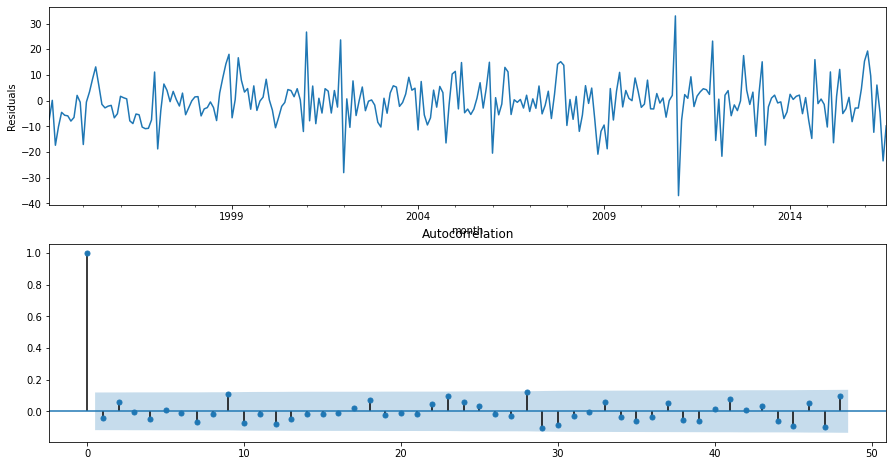

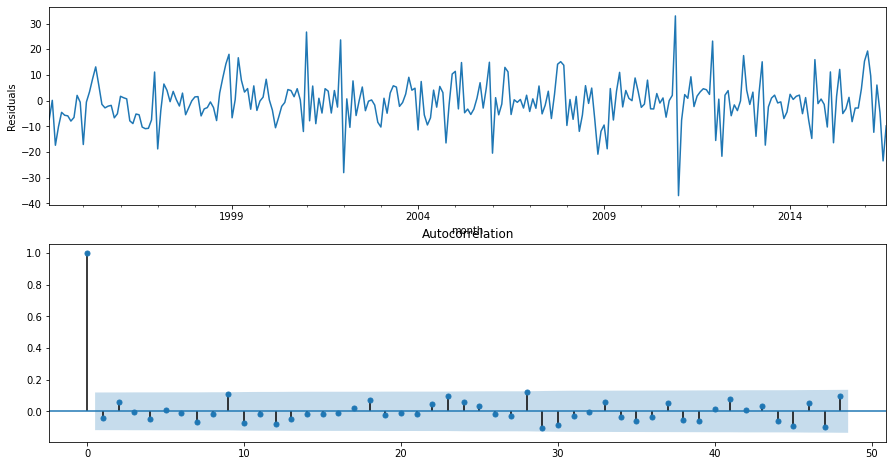

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

In [ ]:
print("Критерий Стьюдента: p=%f" % stats.stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Дики Фуллер: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.269842
Дики Фуллер: p=0.000000


Посмотрим, насколько хорошо наша модель приближает исходные данные. Как можно видеть достаточно неплохо

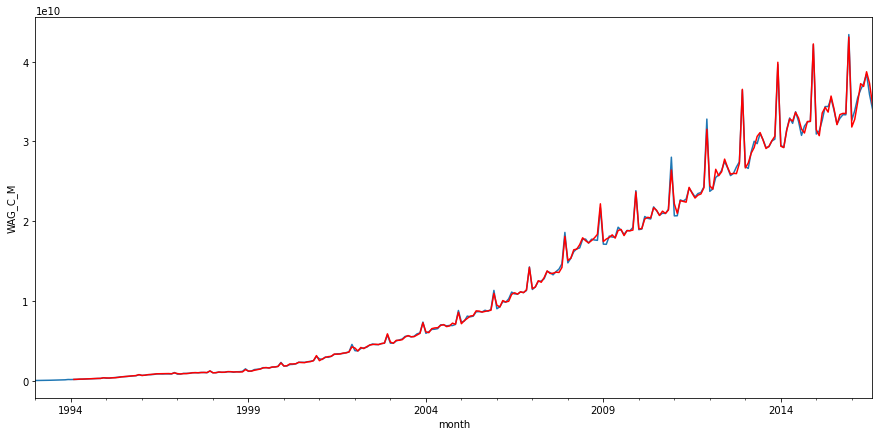

In [ ]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

Далее построим прогноз по заработной плате на 2 года вперёд

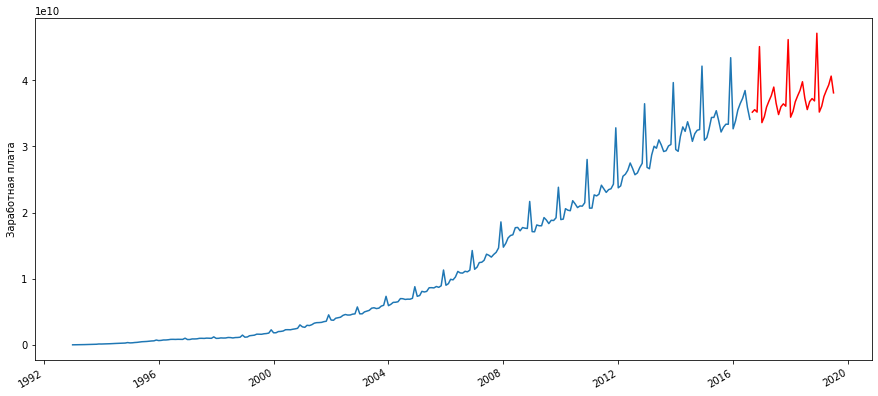

In [ ]:
WAG = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= WAG.columns)
WAG = pd.concat([WAG, future])
WAG['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)
plt.figure(figsize(15,7))
WAG.WAG_C_M.plot()
WAG.forecast.plot(color='r')
plt.ylabel('Заработная плата')
pylab.show()

In [ ]:
invboxcox(best_model.predict(start=284, end=320), lmbda)

In [ ]:
df.WAG_C_M

month
1993-01-01    1.530000e+07
1993-02-01    1.910000e+07
1993-03-01    2.360000e+07
1993-04-01    3.060000e+07
1993-05-01    3.750000e+07
                  ...     
2016-04-01    3.649700e+10
2016-05-01    3.727000e+10
2016-06-01    3.844700e+10
2016-07-01    3.588800e+10
2016-08-01    3.409500e+10
Name: WAG_C_M, Length: 284, dtype: float64